<a href="https://colab.research.google.com/github/LZHbaba/lzh_garbage_classification/blob/main/EfficientNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

模型训练

EfficientNetB7(noisy_student)

**import pre-weights**

In [ ]:
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b1.tar.gz
       
!tar -xf noisy_student_efficientnet-b1.tar.gz

--2022-04-05 08:01:26--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b1.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.8.128, 74.125.23.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.8.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57923575 (55M) [application/octet-stream]
Saving to: ‘noisy_student_efficientnet-b1.tar.gz’

noisy_student_effic 100%[===================>]  55.24M  14.4MB/s    in 3.8s    

2022-04-05 08:01:31 (14.4 MB/s) - ‘noisy_student_efficientnet-b1.tar.gz’ saved [57923575/57923575]



In [ ]:
!python efficientnet_weight_update_util.py --model b1 --notop --ckpt efficientnet-b1/model.ckpt --o efficientnetb1_notop.h5

python3: can't open file 'efficientnet_weight_update_util.py': [Errno 2] No such file or directory


In [ ]:
!pip install -U -q kaggle
import json
token = {"username":"lizhuhang","key":"5e013305ae30811dcd1a581130f07364"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/ 
#这个{"username":"abc","key":"123"}替换成自己的token文件内容
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content
#这就是上一步复制的命令
!kaggle datasets download -d ipythonx/efficientnet-keras-noisystudent-weights-b0b7

- path is now set to: /content
100% 2.48G/2.48G [01:19<00:00, 70.3MB/s]
100% 2.48G/2.48G [01:19<00:00, 33.5MB/s]


In [ ]:
import numpy as np

#import tensorflow to use any tools needed for deep learning
import tensorflow as tf

#import keras api needed to implement deep learning techiques
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
#import libraries for visualization of data
import matplotlib.pyplot as plt
#from tensorflow.random import set_random_seed

#set_random_seed(0) https://zhuanlan.zhihu.com/p/109238035?from_voters_page=true
#np.random.seed(0)

def lr_schedule(epoch):

    lr = 1e-3
    if epoch > 40:
        lr *= 1e-2
    elif epoch > 30:
        lr *= 1e-2
    elif epoch > 20:
        lr *= 1e-1
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr
#Allow charts and graphics to display right below the page of browser setup
%matplotlib inline
#paths to the train, validation and test image datasets 
path = '/content/drive/MyDrive/datasets_garbage/Garbage classification'
#valid_path = '/content/drive/MyDrive/datasets_garbage/Garbage classification'

IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
# extract images to training set by applying data preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.efficientnet.preprocess_input ,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.1)

train_generator=train_datagen.flow_from_directory(
    directory=path, target_size=(IMG_SIZE,IMG_SIZE), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=16, subset='training')


# extract images to validation set
valid_datagen = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.efficientnet.preprocess_input ,
    validation_split=0.1)

val_generator=valid_datagen.flow_from_directory(
    directory=path, target_size=(IMG_SIZE,IMG_SIZE), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=16, subset='validation')


# import the convolution base of the VGG16 model with pre-trained weights
#base_model = tf.keras.applications.resnet.ResNet152(input_shape=IMG_SHAPE, 
                                       # include_top=False,
                                      #  weights='imagenet')
#base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)
base_model=tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    #input_tensor=None,
    input_shape=IMG_SHAPE,
    pooling=None,
    classes=1000,
    classifier_activation='softmax',
    #**kwargs
)
# 默认 drop_connect_rate 为0.2， 如果要更强的正则化，可改
#  model = EfficientNetB0(weights='imagenet', drop_connect_rate=0.4)
model = Sequential()

# Freeze the convolutional base of VGG16 to prevent the pre-trained weights being updated 
# during training inorder to extract features
base_model.trainable=False

# add VGG16 convolution base to initialize sequential model
model.add(base_model)

# add global average pooling layer
model.add(GlobalAveragePooling2D())

# add densely-connected NN layer with 512 hidden units
model.add(Dense(units=512, activation='relu'))  # use ReLU activation function
model.add(BatchNormalization())                 # normalize and scale inputs or activations
model.add(Dropout(0.5))                         # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 128 hidden units
model.add(Dense(units=128, activation='relu')) # use ReLU activation function
model.add(BatchNormalization())                # normalize and scale inputs or activations
model.add(Dropout(0.5))                        # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 6 hidden units
model.add(Dense(units=6, activation='softmax')) # use Softmax activation function to do final predictions
model.summary()
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

import os
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'efficientnetb7_%s_model.{epoch:03d}.h5' 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau,EarlyStopping

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
# https://blog.csdn.net/qq_34418352/article/details/105152893
lr_reducer = ReduceLROnPlateau(monitor='val_loss',factor=0.1,
                               cooldown=0,
                               patience=10,
                               min_lr=0,
                               verbose=1,
                               mode='auto',
                               epsilon=0.001)
# 自动减小学习速率： https://blog.csdn.net/weixin_44048809/article/details/105711356； patience比EarlyStopping小一点才有效果，和早挺搭配使用
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=30)
# https://blog.csdn.net/zwqjoy/article/details/86677030

callbacks = [lr_reducer, es]



In [ ]:
history = model.fit(
   train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size ,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples/val_generator.batch_size,
    verbose=1,
    callbacks = callbacks)
loss = history.history['loss']
validation_loss = history.history['val_loss']
accuracy = history.history['accuracy']
validation_accuracy =history.history['val_accuracy']


base_model.trainable=True # all layers trainable
history = model.fit(
   train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size ,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples/val_generator.batch_size,
    verbose=1,
    callbacks = callbacks)
loss.extend(history.history['loss'])
validation_loss.extend(history.history['val_loss'])
accuracy.extend(history.history['accuracy'])
validation_accuracy.extend(history.history['val_accuracy'])

画 acc, loss 的图 

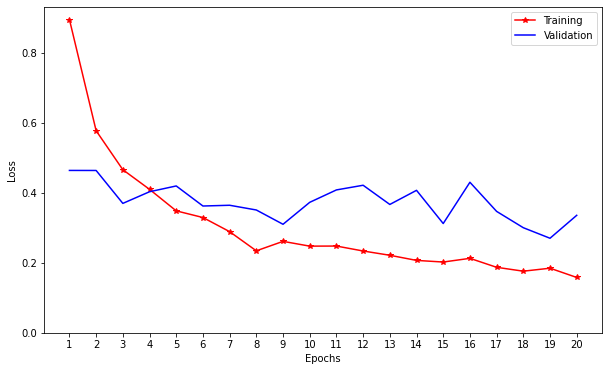

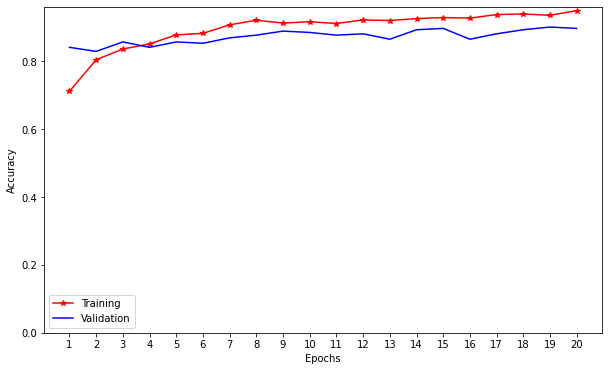

In [ ]:
epochs = range(1, len(loss)+1)

fig1 = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,'r*-',label="Training")
plt.plot(epochs,validation_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0,max(plt.ylim())])
plt.xticks(epochs)
plt.legend()

epochs1 = range(1, len(accuracy)+1)

fig2 = plt.figure(figsize=(10,6))
plt.plot(epochs1,accuracy,'r*-',label="Training")
plt.plot(epochs1,validation_accuracy,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim([0,max(plt.ylim())])
plt.xticks(epochs1)
plt.legend()

保存

In [ ]:
def save_txt(file_name='',object=[]):
    file = open(file_name, 'w')
    file.write(str(object))
    file.close()

model.save_weights('/content/drive/MyDrive/EfficientNet/efficientnetlarge_parameter.h5')#保存模型参数
save_txt('/content/drive/MyDrive/EfficientNet/loss.txt',loss)
save_txt('/content/drive/MyDrive/EfficientNet/val_loss.txt',validation_loss)
save_txt('/content/drive/MyDrive/EfficientNet/acc.txt',accuracy)
save_txt('/content/drive/MyDrive/EfficientNet/val_acc.txt',validation_accuracy)

保存整个模型

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')

ValueError: ignored

**download the whole model**

In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model')
# Check its architecture
new_model.summary()

In [ ]:
# model2 = create_model()
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model2 = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights=None, input_shape=IMG_SHAPE)
model2 = Sequential()
model2.add(base_model2)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(units=512, activation='relu'))  # use ReLU activation function
model2.add(BatchNormalization())                 # normalize and scale inputs or activations
model2.add(Dropout(0.2))                         # applies dopout to the input which will randomly disable 20% of hidden units
model2.add(Dense(units=128, activation='relu')) # use ReLU activation function
model2.add(BatchNormalization())                # normalize and scale inputs or activations
model2.add(Dropout(0.2))                        # applies dopout to the input which will randomly disable 20% of hidden units
model2.add(Dense(units=6, activation='softmax'))
model2.load_weights('/content/drive/MyDrive/EfficientNet/efficientnetlarge_parameter.h5')#下载模型参数
model2.summary()

预测图片：

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
path = '/content/drive/MyDrive/datasets_garbage/Garbage classification'
#valid_path = '/content/drive/MyDrive/datasets_garbage/Garbage classification'


# extract images to training set by applying data preprocessing and data augmentation
train_batches = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.efficientnet.preprocess_input ,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.1).flow_from_directory(
    directory=path, target_size=(224,224), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=16, subset='training')
TrainImageClasses = train_batches.class_indices
print(TrainImageClasses)
table = {}
for imageVal, imageName in zip(TrainImageClasses.values(), TrainImageClasses.keys()):
    table[imageVal] = imageName

Found 2276 images belonging to 6 classes.
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [ ]:
from keras.backend import dtype
import numpy as np
from keras.preprocessing import image
ImagePath='/content/drive/MyDrive/datasets_garbage/Garbage classification/glass/glass104.jpg'
test_image=image.load_img(ImagePath,target_size=(224, 224))
#print(test_image.size)#现在的图片还不是数组形式的，所以没有shape1函数(224, 224)
test_image=image.img_to_array(test_image)
#print(test_image.dtype)#float32
#print(test_image.shape)#(224, 224, 3)
test_image=np.expand_dims(test_image,axis=0)
#print(test_image.shape)#(1, 224, 224, 3)
result=model2.predict(test_image,verbose=0)
#print(training_set.class_indices)
print('####'*10)
print('Prediction is: ',table[np.argmax(result)])
plt.title("Loaded Image")
plt.axis('off')
image=np.array(test_image)/225
plt.imshow(image.squeeze())

(224, 224)
float32
(224, 224, 3)
(1, 224, 224, 3)


In [ ]:
test_image=image.load_img('/content/drive/MyDrive/outside_url/picture.jpg',target_size=(224, 224))

**connect the anvil**

In [ ]:
import urllib.request
from PIL import Image
from keras.preprocessing import image as ig
!pip install anvil-uplink
import anvil.server
from tensorflow.keras.preprocessing.image import ImageDataGenerator
path = '/content/drive/MyDrive/datasets_garbage/Garbage classification'
anvil.server.connect("MO5GXYH2BNZVQAPL5G4GOBYI-EEGR56LYS6J5GIZN")
train_batches = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.efficientnet.preprocess_input ,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.1).flow_from_directory(
    directory=path, target_size=(224,224), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=16, subset='training')
TrainImageClasses = train_batches.class_indices
print(TrainImageClasses)
table = {}
for imageVal, imageName in zip(TrainImageClasses.values(), TrainImageClasses.keys()):
    table[imageVal] = imageName

@anvil.server.callable
def predict_external_image(imagePath):
    import numpy as np
    savepath='/content/drive/MyDrive/outside_url/picture.jpg'
    urllib.request.urlretrieve(imagePath,savepath)
    #image = Image.open(savepath)
    test_image=ig.load_img(savepath,target_size=(224, 224))
    test_image=ig.img_to_array(test_image)
    test_image=np.expand_dims(test_image,axis=0)
    result=model2.predict(test_image,verbose=0)
    labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
    predicted_class = table[np.argmax(result)]
    #example_image = transformations(image)
    image1=np.array(test_image)/225
    plt.imshow(image1.squeeze())
    print("The image resembles", predicted_class + ".")
    return predicted_class


  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


Found 2276 images belonging to 6 classes.
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image resembles plastic.


'plastic'

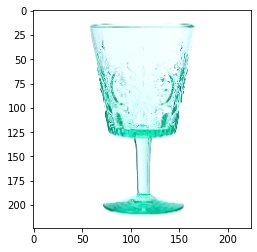

In [ ]:
imagePath='https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse3.mm.bing.net%2Fth%3Fid%3DOIP.G37FJ-GhP9SrFxc8Msx16gHaHa%26pid%3DApi&f=1'
#savepath='/content/drive/MyDrive/outside_url/picture.jpg'
#urllib.request.urlretrieve(imagePath,savepath)
predict_external_image(imagePath)

In [ ]:
test_image=ig.load_img(savepath,target_size=(224, 224))
test_image=ig.img_to_array(test_image)
test_image=np.expand_dims(test_image,axis=0)
#result=model2.predict(test_image,verbose=0)

In [ ]:
result=model2.predict(test_image,verbose=0)
result

array([[1.1354252e-04, 1.3717365e-01, 1.0340491e-02, 6.9373241e-04,
        8.5159296e-01, 8.5563552e-05]], dtype=float32)

In [ ]:
predicted_class = labels[np.argmax(result[0], axis=-1)]
predicted_class

'plastic'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Maximum Probability:  0.4572308
Classified: paper


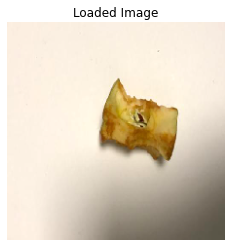

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
img_path = '/content/drive/MyDrive/datasets_garbage/Garbage classification/trash/trash101.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img)
p=model2.predict(img[np.newaxis, ...])

plt.title("Loaded Image")
plt.axis('off')
image=np.array(img)/225
plt.imshow(image.squeeze())

#p=model2.predict(img[np.newaxis, ...])
#print(p)
#print("Predicted shape",p.shape)
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)



画bar图

In [ ]:
classes=[]
prob=[]
print("\n-------------------Individual Probability--------------------------------\n")

for i,j in enumerate (p[0],0):
    print(labels[i].upper(),':',round(j*100,2),'%')#向上取整保留两位小数
    classes.append(labels[i])
    prob.append(round(j*100,2))#将概率和分类都append到list中
    
def plot_bar_x(imagePath):
    import numpy as np
    savepath='/content/drive/MyDrive/outside_url/picture.jpg'
    urllib.request.urlretrieve(imagePath,savepath)
    #image = Image.open(savepath)
    test_image=ig.load_img(savepath,target_size=(224, 224))
    test_image=ig.img_to_array(test_image)
    test_image=np.expand_dims(test_image,axis=0)
    result=model2.predict(test_image,verbose=0)
    classes=[]
    prob=[]
    labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
    for i,j in enumerate (result[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')#向上取整保留两位小数
        classes.append(labels[i])
        prob.append(round(j*100,2))#将概率和分类都append到list中
        # this is for plotting purpose
    index = np.arange(len(classes))#【0，1，2，3，4，5】
    plt.bar(index, prob)#画出bar
    plt.xlabel('Labels', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.xticks(index, classes, fontsize=12, rotation=20)#标下标，旋转20°
    plt.title('Probability for loaded image')
    plt.show()


#plot_bar_x()


-------------------Individual Probability--------------------------------

CARDBOARD : 15.13 %
GLASS : 0.02 %
METAL : 6.96 %
PAPER : 45.72 %
PLASTIC : 0.0 %
TRASH : 32.16 %


CARDBOARD : 0.01 %
GLASS : 13.72 %
METAL : 1.03 %
PAPER : 0.07 %
PLASTIC : 85.16 %
TRASH : 0.01 %


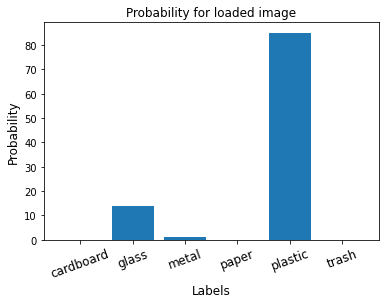

In [ ]:
imagePath='https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse3.mm.bing.net%2Fth%3Fid%3DOIP.G37FJ-GhP9SrFxc8Msx16gHaHa%26pid%3DApi&f=1'
plot_bar_x(imagePath)

In [ ]:
classes=[]
prob=[]
for i,j in enumerate(p[0]):
  print(labels[i].upper(),':',round(j*100,2),'%')
  classes.append(labels[i])
  prob.append(round(j*100,2))

CARDBOARD : 55.87 %
GLASS : 27.98 %
METAL : 66.29 %
PAPER : 54.4 %
PLASTIC : 0.69 %
TRASH : 98.82 %


[0 1 2 3 4 5]


([<matplotlib.axis.XTick at 0x7f720b851690>,
 [Text(0, 0, 'cardboard'),
  Text(0, 0, 'glass'),
  Text(0, 0, 'metal'),
  Text(0, 0, 'paper'),
  Text(0, 0, 'plastic'),
  Text(0, 0, 'trash')])

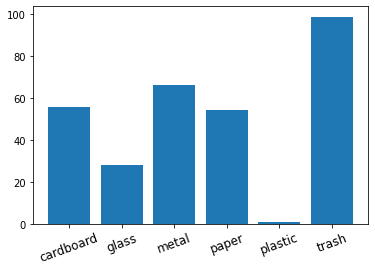

In [ ]:
index = np.arange(len(classes))
print(index)
plt.bar(index, prob)
plt.xticks(index, classes, fontsize=12, rotation=20)

In [ ]:
round(j*100,2)

98.82

画 confusion matrix 图

In [ ]:
valid_batches = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.efficientnet.preprocess_input ,
    validation_split=0.1).flow_from_directory(
    directory=path, target_size=(224,224), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=16, subset='validation')
x_test, y_test = valid_batches[12] #16张图片，batch_size=16
y_pred = model2.predict(x_test)
print(x_test)#[0,225]
print(y_pred)#[0,1]

In [ ]:
print(y_test.shape) #(16, 6)
print(x_test.shape)#(16, 224, 224, 3)
print(y_pred.shape)#(16, 6)

(16, 6)
(16, 224, 224, 3)
(16, 6)


In [ ]:
y_test2=np.argmax(y_test,axis=1)
print(y_test2)

[2 0 5 0 3 2 2 4 1 0 3 0 2 3 3 2]


In [ ]:
y_pred2=np.argmax(y_pred,axis=1)
y_pred2

array([2, 0, 5, 0, 3, 2, 2, 4, 1, 0, 3, 0, 2, 3, 3, 2])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
cm = confusion_matrix(y_test2, y_pred2) #

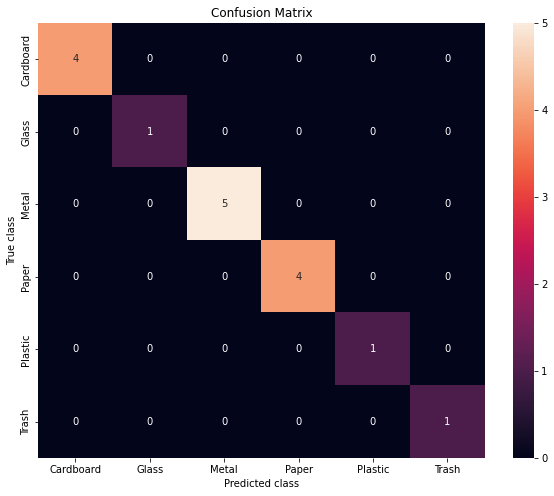

In [ ]:
import pandas as pd
import seaborn as sns
LABELS=['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']
cm_df = pd.DataFrame(cm,index = LABELS, columns = LABELS)

plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix \nAccuracy:{0:.3f}'.format(accuracy_score(y_test2, y_pred2)))
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


In [ ]:
print(y_test)

[[0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [ ]:
y_pred

array([[1.86623311e-06, 2.09907193e-05, 9.99969363e-01, 2.58562835e-07,
        3.14907493e-06, 4.41088878e-06],
       [9.99973416e-01, 1.75913246e-05, 7.04371678e-06, 1.37761589e-08,
        5.90970842e-07, 1.27426620e-06],
       [5.80992043e-01, 5.17364970e-06, 2.38931030e-01, 1.78426817e-01,
        4.77548543e-04, 1.16733694e-03],
       [3.53988298e-07, 1.28753716e-04, 3.40929489e-07, 2.03447307e-05,
        9.99843597e-01, 6.57076453e-06],
       [1.19877939e-07, 2.68785661e-04, 9.99643922e-01, 2.29799698e-05,
        7.71104988e-06, 5.63650465e-05],
       [7.10043314e-05, 1.85416104e-06, 3.88486187e-05, 9.99399304e-01,
        4.55672969e-04, 3.33079224e-05],
       [9.99759853e-01, 1.39506437e-05, 6.36072218e-05, 1.44212725e-04,
        2.84419320e-06, 1.55153193e-05],
       [5.88633375e-05, 9.82520521e-01, 1.09996786e-02, 1.74103174e-04,
        5.56155248e-03, 6.85209583e-04],
       [1.67995502e-04, 1.32711039e-05, 9.95968223e-01, 3.40367970e-03,
        5.42115413e-05, 

In [ ]:
np.argmax(y_test,axis=1)#每一行最大的index

array([2, 0, 0, 4, 2, 3, 0, 1, 2, 3, 3, 1, 0, 3, 3, 3])

In [ ]:
idxs = np.argmax(y_test, axis=1)==0
idxs

array([False,  True,  True, False, False, False,  True, False, False,
       False, False, False,  True, False, False, False])

In [ ]:
num_samples_per_class = np.count_nonzero(idxs)
num_samples_per_class

4

In [ ]:
this_label = y_test[idxs]
this_label

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
x_test[idxs].shape#(4, 224, 224, 3)

(4, 224, 224, 3)

In [ ]:
model2.predict(x_test[idxs])

array([[9.99973416e-01, 1.75912228e-05, 7.04370314e-06, 1.37761065e-08,
        5.90973116e-07, 1.27426267e-06],
       [5.80993176e-01, 5.17363014e-06, 2.38930002e-01, 1.78426698e-01,
        4.77550144e-04, 1.16733927e-03],
       [9.99759853e-01, 1.39505510e-05, 6.36072218e-05, 1.44212347e-04,
        2.84417683e-06, 1.55153193e-05],
       [9.99983191e-01, 3.26138007e-07, 8.30949489e-07, 1.04876353e-05,
        1.34765656e-07, 4.99074986e-06]], dtype=float32)

In [ ]:
np.argmax(model2.predict(x_test[idxs]), axis=1)

array([0, 0, 0, 0])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from keras.models import Sequential

import glob, os, random

In [ ]:
base_path = '/content/drive/MyDrive/datasets_garbage/Garbage classification'

img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))
print(img_list)
print(len(img_list))

['/content/drive/MyDrive/datasets_garbage/Garbage classification/glass/glass442.jpg', '/content/drive/MyDrive/datasets_garbage/Garbage classification/glass/glass188.jpg', '/content/drive/MyDrive/datasets_garbage/Garbage classification/glass/glass348.jpg', '/content/drive/MyDrive/datasets_garbage/Garbage classification/glass/glass370.jpg', '/content/drive/MyDrive/datasets_garbage/Garbage classification/glass/glass430.jpg', '/content/drive/MyDrive/datasets_garbage/Garbage classification/glass/glass209.jpg', '/content/drive/MyDrive/datasets_garbage/Garbage classification/glass/glass477.jpg', '/content/drive/MyDrive/datasets_garbage/Garbage classification/glass/glass285.jpg', '/content/drive/MyDrive/datasets_garbage/Garbage classification/glass/glass315.jpg', '/content/drive/MyDrive/datasets_garbage/Garbage classification/glass/glass398.jpg', '/content/drive/MyDrive/datasets_garbage/Garbage classification/glass/glass282.jpg', '/content/drive/MyDrive/datasets_garbage/Garbage classification/

In [ ]:
import matplotlib.image as mpimg
plt.figure(figsize=(30,14))

train_dir = os.path.join('/content/drive/MyDrive/datasets_garbage/Garbage classification')
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


for i in range(6):
    directory = os.path.join(train_dir, labels[i])
    for j in range(10):
        path = os.path.join(directory, os.listdir(directory)[j])
        img = mpimg.imread(path)
        
        plt.subplot(6, 10, i*10 + j + 1)
        plt.imshow(img)
        
        if j == 0:
            plt.ylabel(labels[i], fontsize=20)
        
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

#import tensorflow to use any tools needed for deep learning
import tensorflow as tf

#import keras api needed to implement deep learning techiques
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/datasets_garbage/Garbage classification'

from tensorflow.random import set_random_seed
set_random_seed(2022) #https://zhuanlan.zhihu.com/p/109238035?from_voters_page=true
np.random.seed(2022)
SEED=2022
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
# extract images to training set by applying data preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    #shear_range=0.2,
    #zoom_range=0.2,
    width_shift_range=0.2,
    #height_shift_range=0.2,
    )

train_generator=train_datagen.flow_from_directory(
    directory=path, target_size=(IMG_SIZE,IMG_SIZE), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=16, subset='training',seed=SEED)





ImportError: ignored

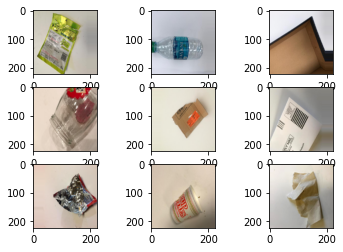

In [ ]:
from matplotlib import pyplot
for batch_data, batch_label in train_generator:
    for i in range(0, 9):
        # 创建一个 3*3的九宫格，以显示图片
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(array_to_img(batch_data[i]))
    pyplot.show()
    break
